<a href="https://colab.research.google.com/github/liuJwei/Learning-CoLab/blob/master/load_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook shows how to test the HD3 pretrained model in Google Colab.

Download the file from the [GitHub](https://github.com/ucbdrive/hd3) and unzip it.

In [120]:
# current workplace
!pwd

/content/hd3-master


In [0]:
!unzip hd3-master.zip


In [0]:
# change work directory
import os
os.chdir('./hd3-master')


In [0]:
import hd3model as models
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn

corr_range = [4, 4, 4, 4, 4, 4]



I tried to write the code below to test it, but it doesn't work at the beginning.
After I add the **args.context**, it works. 

In [0]:
model = models.HD3Model('stereo', 'dlaup', 'hda', corr_range, '--context').cuda()

import logging
# logger
def get_logger():
    logger_name = "main-logger"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    fmt = "[%(asctime)s %(levelname)s %(filename)s line %(lineno)d %(process)d] %(message)s"
    handler.setFormatter(logging.Formatter(fmt))
    logger.addHandler(handler)
    return logger
  
logger = get_logger()  
# logger.info(model)


model = nn.DataParallel(model).cuda()
cudnn.enabled = True
cudnn.benchmark = True


from IPython.core.debugger import set_trace

def load_pretrained_model(filepath):
    # this model was trained on gpu
    pretrained = torch.load(filepath)
#     set_trace()
    #model = pretrained['model']
    model.load_state_dict(pretrained['state_dict'], strict= True)
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

# Don't know why i cannot load the model successfully.    
model = load_pretrained_model('hd3sc_things_kitti-368975c0.pth')

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Install cupy.

In [10]:
!pip install cupy-cuda100

     |████████████████████████████████| 354.4MB 64kB/s 


Download pretrained model from the website.

In [0]:
!wget dl.yf.io/hd3/models/hd3f_chairs-04bf114d.pth

In [0]:
# Download file to a specific address
!wget dl.yf.io/hd3/models/hd3sc_things_kitti-368975c0.pth -O ../hd3-master/000.pth

In [0]:
!wget --help

Try to run the inference.py directly. It works.

In [115]:
# Write a data list of a image pair to read
# Creat a folder test_data in the current working dictionary to put image pairs
%%writefile lists/my_list.txt
test_data/image_2/000000_10.png test_data/image_3/000000_10.png

Overwriting lists/my_list.txt


In [127]:
import time
start = time.time()

!python -u inference.py \
  --task=stereo \
  --data_root= \
  --data_list='lists/my_list.txt'\
  --context \
  --encoder=dlaup \
  --decoder=hda \
  --batch_size=1 \
  --workers=16 \
  --flow_format=png \
  \
  --model_path='hd3sc_things_kitti-368975c0.pth' \
  --save_folder=path_to_save_predictions

end = time.time()

print(end - start, '[s]')

[2019-07-02 02:26:02,954 INFO inference.py line 78 5677] Namespace(batch_size=1, context=True, data_list='lists/my_list.txt', data_root='', decoder='hda', encoder='dlaup', evaluate=False, flow_format='png', model_path='hd3sc_things_kitti-368975c0.pth', save_folder='path_to_save_predictions', task='stereo', workers=16)
[2019-07-02 02:26:02,954 INFO inference.py line 79 5677] => creating model ...
[2019-07-02 02:26:08,083 INFO inference.py line 121 5677] HD3Model(
  (hd3net): HD3Net(
    (encoder): DLAUpEncoder(
      (base): DLA(
        (base_layer): Sequential(
          (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
        (level0): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running

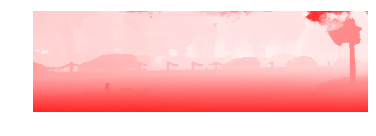

In [124]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('path_to_save_predictions/vis/test_data/image_2/000000_10.png')
plt.imshow(img); plt.axis('off')
plt.show()